In [1]:
import datetime as dt
import xarray as xr
import pandas
import matplotlib.pyplot as plt
import numpy as np
####################you will need to change some paths here!#####################
#list of input directories
dir_storm_wmo='F:/data/tc_wakes/ibtracks/year/'
dir_storm_info='f:/data/tc_wakes/database/info/'


C:\Users\gentemann\Miniconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [3]:
lyr=2003
filename=dir_storm_wmo+'Year.'+str(lyr)+'.ibtracs_wmo.v03r10.nc'
ds_storm_info = xr.open_dataset(filename)
ds_storm_info.close()
ds_storm_info

<xarray.Dataset>
Dimensions:          (center: 26, storm: 97, time: 137)
Dimensions without coordinates: center, storm, time
Data variables:
    storm_sn         (storm) |S13 ...
    name             (storm) |S57 ...
    numObs           (storm) int16 ...
    season           (storm) int16 ...
    track_type       (storm) int8 ...
    genesis_basin    (storm) int8 ...
    num_basins       (storm) int8 ...
    basin            (storm, time) float32 ...
    wind_avg_period  (center) float32 ...
    source           (center) |S10 ...
    time_wmo         (storm, time) datetime64[ns] ...
    lat_wmo          (storm, time) float32 ...
    lon_wmo          (storm, time) float32 ...
    alt              (storm, time) float32 ...
    wind_wmo         (storm, time) float32 ...
    pres_wmo         (storm, time) float32 ...
    sub_basin        (storm, time) float32 ...
    nature_wmo       (storm, time) float32 ...
    source_wmo       (storm, time) float32 ...
    dist2land        (storm, time

In [4]:
#storm number in wmo file is -1 from storm number used by other routines to index storms
#eg info/2003/006storm  is actually for wmo storm 5 
ds_storm_info.storm

<xarray.DataArray 'storm' (storm: 97)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96], dtype=int64)
Dimensions without coordinates: storm

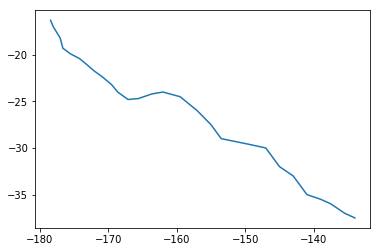

In [6]:
subset = ds_storm_info.sel(storm=2)
plt.plot(subset.lon_wmo,subset.lat_wmo)

In [8]:
subset.name

<xarray.DataArray 'name' ()>
array(b'YOLANDE', dtype='|S57')
Attributes:
    long_name:  Storm name

In [ ]:
#from storm_masking_routines import interpolate_storm_path
import numpy as np
from scipy import interpolate
import xarray as xr

#after calculating the distance from the storm it became clear that the storm data is every 6 hours, no matter 
#how much it may have moved.  So if the storm moved 300 km in 6 hr, when calculating the distance to the storm
#there were points on the storm track that showed large distances because of the separation to the 6hrly storm points
#this subroutine interpolates the storm path onto a higher spatial resolution
#the new storm dataset is carefully put into an identical format with i2 and j2 as dims to match the old format
ynew = []
tnew = []
xnew = []
subset['lon_wmo'] = (subset.lon_wmo-180) % 360 - 180 #put -180 to 180
for istep in range(1,subset.lon_wmo.shape[0]):
    dif_lat = subset.lat_wmo[istep]-subset.lat_wmo,istep-1]
    dif_lon = subset.lon_wmo[istep]-subset.lon_wmo[istep-1]
    x,y,t = subset.lon_wmo[istep-1:istep+1].values,subset.lat_wmo[istep-1:istep+1].values,subset.time_wmo[istep-1:istep+1].values
    x1,y1,t1 = subset.lon_wmo[istep-1:istep].values,subset.lat_wmo[istep-1:istep].values,subset.time_wmo[istep-1:istep].values
    if abs(dif_lat)>abs(dif_lon):
        isign = np.sign(dif_lat)
        if abs(dif_lat)>0.75:
            ynew1 = np.arange(y[0], y[-1], isign.data*0.75)
            f = interpolate.interp1d(y, x, assume_sorted=False)
            xnew1 = f(ynew1)
            f = interpolate.interp1d(y, t, assume_sorted=False)
            tnew1 = f(ynew1)
        else:
            xnew1,ynew1,tnew1 = x1,y1,t1
        xnew,ynew,tnew = np.append(xnew,xnew1),np.append(ynew,ynew1),np.append(tnew,tnew1) 
    else:
        isign = np.sign(dif_lon)
        if abs(dif_lon)>0.75:
            iwrap_interp = 1
            if (x[0]<-90) & (x[-1]>90):
                iwrap_interp = -1
                x[0]=x[0]+360
            if (x[0]>90) & (x[-1]<-90):
                iwrap_interp = -1
                x[-1]=x[-1]+360
            xnew1 = np.arange(x[0], x[-1], iwrap_interp*isign.data*0.75)
            f = interpolate.interp1d(x, y, assume_sorted=False)
            ynew1 = f(xnew1)
            f = interpolate.interp1d(x, t, assume_sorted=False)
            tnew1 = f(xnew1)
            xnew1 = (xnew1 - 180) % 360 - 180 #put -180 to 180
        else:
            xnew1,ynew1,tnew1 = x1,y1,t1
        xnew,ynew,tnew = np.append(xnew,xnew1),np.append(ynew,ynew1),np.append(tnew,tnew1) 
#remove any repeated points
ilen=xnew.size
outputx,outputy,outputt=[],[],[]
for i in range(ilen-1):
    if (xnew[i]==xnew[i+1]) and (ynew[i]==ynew[i+1]):
        continue
    else:
        outputx,outputy,outputt = np.append(outputx,xnew[i]),np.append(outputy,ynew[i]),np.append(outputt,tnew[i])
xnew,ynew,tnew=outputx,outputy,outputt
#put into xarray
i2,j2=xnew.shape[0],1
tem = np.expand_dims(xnew, axis=0)
xx = xr.DataArray(tem.T,dims=['i2','j2'])
tem = np.expand_dims(ynew, axis=0)
yy = xr.DataArray(tem.T,dims=['i2','j2'])
tem = np.expand_dims(tnew, axis=0)
tt = xr.DataArray(tem.T,dims=['i2','j2'])
dsx_new = xr.Dataset({'lon':xx.T,'lat':yy.T,'time':tt.T})

